In [ ]:
! export CUDA_VISIBLE_DEVICES=2

In [1]:
from collections import OrderedDict
from utils.tokenizer import SimpleTokenizer
import models.ULIP_models as models
from main import get_args_parser
import argparse
from utils import utils
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import random

In [3]:
from ULIP_ShapeNet_Dataset.ULIP_ShapeNet import ULIP_ShapeNet

In [4]:
import torch

# 打印所有可用的设备名称
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA A100-PCIE-40GB


In [5]:
# GPU_IDX = 2

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_IDX)
# print(os.environ["CUDA_VISIBLE_DEVICES"])


In [7]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [8]:
import torch

print(torch.cuda.current_device())        # 当前设备的索引
print(torch.cuda.device_count())          # 可用的设备数量
print("CUDA device name:", torch.cuda.get_device_name(0))    # 设备 0 的名称

0
1
CUDA device name: NVIDIA A100-PCIE-40GB


Current support class

In [9]:
# Define class names and descriptions
shapenet_classes = ['plane', 'table', 'chair']

descriptions = []
for i, sn_class in enumerate(shapenet_classes):
    descriptions.append(f'This is an image of a 3D rendering {sn_class}')
    # descriptions.append(f'This is an image of a {sn_class}')

print(descriptions)

['This is an image of a 3D rendering plane', 'This is an image of a 3D rendering table', 'This is an image of a 3D rendering chair']


Load the ULIP ShapeNet dataset

In [10]:
keyword = "plane"
# keyword = None

dataset = ULIP_ShapeNet(keyword=keyword)
print(len(dataset))

data, RGB_imgs_show = dataset.process_index(show_images=True)

2860


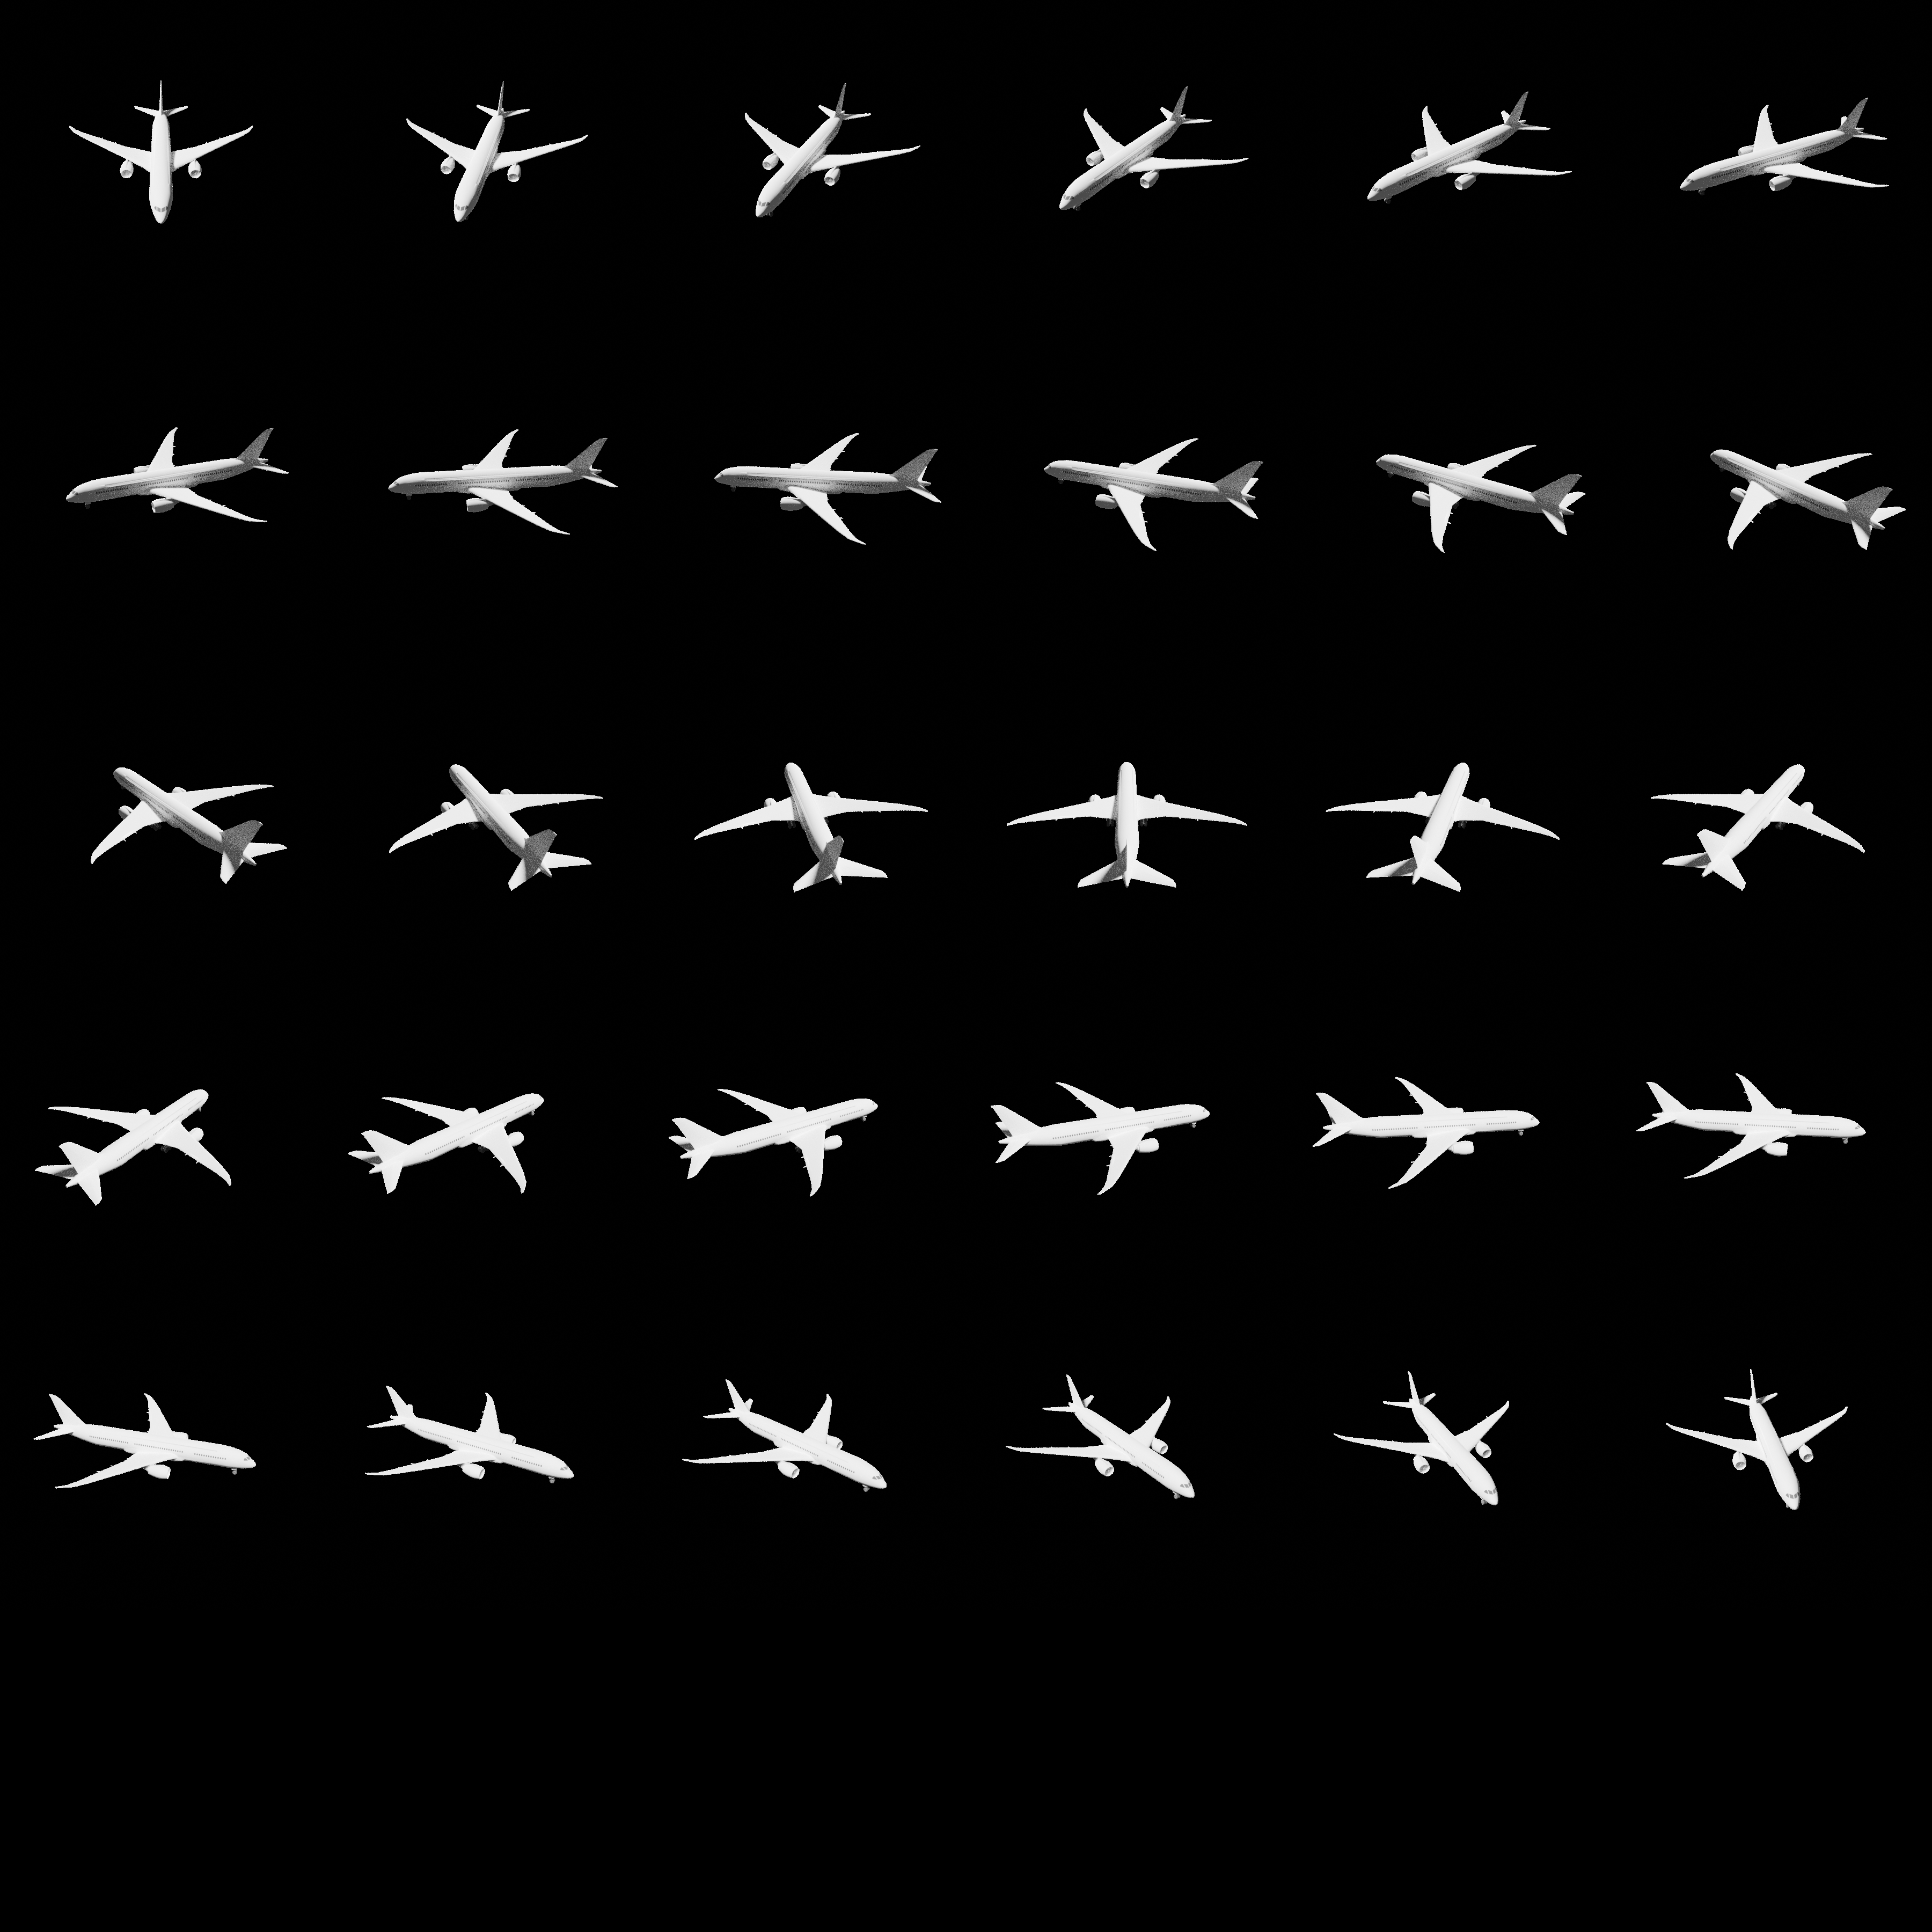

In [11]:
RGB_imgs_show

In [12]:
dataset.visualize_pointcloud(data["pointcloud_np"])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0002286…

In [13]:
index_A, index_B = dataset.choose_random_angles(data, 60)

In [14]:
angle_A = data[f"angle_{index_A}"]["angle"]
image_A = data[f"angle_{index_A}"]["image"]
angle_B = data[f"angle_{index_B}"]["angle"]
image_B = data[f"angle_{index_B}"]["image"]
captions_B = data[f"angle_{index_B}"]["captions"]

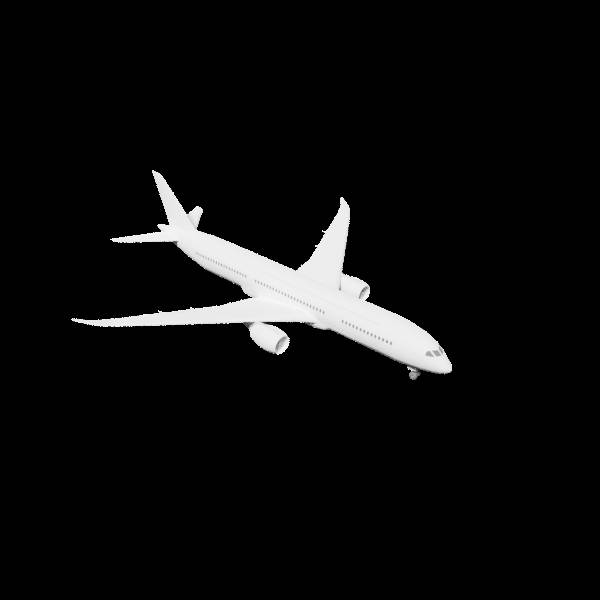

In [15]:
image_A

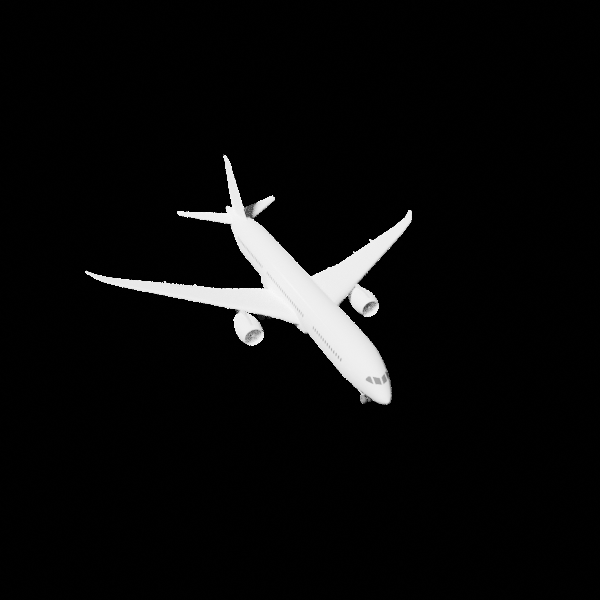

In [16]:
image_B

In [17]:
print(angle_A)
print(angle_B)
print(abs(angle_A - angle_B))

312
336
24


In [18]:
captions_B

['a drawing of an airplane on a gray background',
 'there is a plane flying in a grey background',
 'an airplane flying through the sky as gray background',
 'a plane in a grey color on the sky',
 'an image of a airplane in the air',
 'a white plane flies over a grey sky',
 'the view of a small plane flying through the air',
 'a 3D plane flies through the sky',
 'an airplane flying through the air towards the camera',
 'a plane flying on a cloud and a building in the background']

Load the ULIP pretrained 3D encoder

In [19]:
def create_fake_args():
    parser = argparse.ArgumentParser('ULIP training and evaluation', parents=[get_args_parser()])
    fake_args = parser.parse_args([])  # 使用空列表初始化命名空间
    # 手动设置每个参数的值
    fake_args.output_dir = './outputs'
    # fake_args.npoints = 8192
    fake_args.npoints = 10000
    fake_args.model = 'ULIP2_PointBERT_Colored'
    fake_args.gpu = 0
    # fake_args.test_ckpt_addr = './pretrained_models/pointbert_ULIP-2.pt'
    fake_args.test_ckpt_addr = './pretrained_models/ULIP-2-PointBERT-10k-colored-pc-pretrained.pt'
    fake_args.evaluate_3d_ulip2 = True
    return fake_args

args = create_fake_args()

In [20]:
ckpt = torch.load(args.test_ckpt_addr, map_location='cpu')

# 遍历状态字典并移除 'module.' 前缀
state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    state_dict[k.replace('module.', '')] = v


In [21]:
# 打印处理后的状态字典
# for k, v in state_dict.items():
#     print(k, v.size())

In [22]:
print("=> creating model: {}".format(args.model))

# create the model
model = getattr(models, args.model)(args=args)
model.cuda()

print("")

=> creating model: ULIP2_PointBERT_Colored
Get openclip model:
Finished loading the openclip model.
PointTransformer_Colored model size:
32.50M



In [23]:
# load the parameters
model.load_state_dict(state_dict, strict=False)
# model.load_state_dict(state_dict, strict=True)

print("=> loaded pretrained checkpoint '{}'".format(args.test_ckpt_addr))

=> loaded pretrained checkpoint './pretrained_models/ULIP-2-PointBERT-10k-colored-pc-pretrained.pt'


In [24]:
model.eval()

print("")

In [25]:
tokenizer = SimpleTokenizer()

In [26]:
with torch.no_grad():
    
    texts = tokenizer(descriptions).cuda(args.gpu, non_blocking=True)
    print(texts.shape)
    
    if len(texts.shape) < 2:
        texts = texts[None, ...]
    print(texts.shape)
    

torch.Size([3, 77])
torch.Size([3, 77])


In [27]:
with torch.no_grad():
    # class_embeddings = utils.get_model(model).encode_text(texts).float()
    class_embeddings = model.encode_text(texts).float()
    class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
    
    print(class_embeddings.shape)

torch.Size([3, 1280])


Similarity between the image and the class descriptions

In [28]:
image_A_tensor = model.preprocess(image_A)
image_B_tensor = model.preprocess(image_B)

# 检查转换后的 tensor 的形状和类型
print(image_A_tensor.shape)  # 应该输出 [C, H, W]
print(image_A_tensor.dtype)  # 应该输出 torch.float32

torch.Size([3, 224, 224])
torch.float32


In [29]:
with torch.no_grad():
    img_A_embedding = model.encode_image(image_A_tensor.unsqueeze(0).cuda()).float()
    img_A_embedding = img_A_embedding / img_A_embedding.norm(dim=-1, keepdim=True)
    
    img_B_embedding = model.encode_image(image_B_tensor.unsqueeze(0).cuda()).float()
    img_B_embedding = img_B_embedding / img_B_embedding.norm(dim=-1, keepdim=True)
    
    print(img_A_embedding.shape)

torch.Size([1, 1280])


In [30]:
logits_img_A = img_A_embedding @ class_embeddings.t()
prob_img_A = F.softmax(logits_img_A, dim=-1)

print(logits_img_A)
print(prob_img_A)

logits_img_B = img_B_embedding @ class_embeddings.t()
prob_img_B = F.softmax(logits_img_B, dim=-1)

print(logits_img_B)
print(prob_img_B)

tensor([[0.4366, 0.2976, 0.2654]], device='cuda:0')
tensor([[0.3686, 0.3208, 0.3106]], device='cuda:0')
tensor([[0.4238, 0.2766, 0.2579]], device='cuda:0')
tensor([[0.3690, 0.3185, 0.3126]], device='cuda:0')


In [31]:
predicted_classes_img_A = torch.argmax(prob_img_A, dim=-1)
print("Predicted class of the image: " + shapenet_classes[predicted_classes_img_A])

predicted_classes_img_B = torch.argmax(prob_img_B, dim=-1)
print("Predicted class of the image: " + shapenet_classes[predicted_classes_img_B])

Predicted class of the image: plane
Predicted class of the image: plane


In [32]:
sim_img_A_B = img_A_embedding @ img_B_embedding.t()
print(sim_img_A_B)

tensor([[0.9710]], device='cuda:0')


Similarity between the point cloud and the class descriptions

In [54]:
pc_tensor = dataset.pc_numpy2tensor(data["pointcloud_np"])
print(pc_tensor.shape)

torch.Size([1, 8192, 3])


In [55]:
range_info, center_info, range_normalized, center_normalized = dataset.check_normalization(pc_tensor)
print(range_info)
print(center_info)

The point cloud range is normalized to [-1, 1].
The point cloud is centered at [-0.00029170445013874144, 0.012917461049250897, 0.07038575771220801].


In [56]:
B, N, _ = pc_tensor.shape

# rgb_tensor = torch.zeros((B, N, 3))
# rgb_tensor = torch.ones((B, N, 3))
rgb_tensor = torch.ones((B, N, 3)) * 100.0

In [57]:
pc_rgb_tensor = torch.cat((pc_tensor, rgb_tensor), dim=-1)
print("Combined tensor shape:", pc_rgb_tensor.shape)

Combined tensor shape: torch.Size([1, 8192, 6])


In [58]:
with torch.no_grad():

    pc = pc_rgb_tensor.float().cuda(args.gpu, non_blocking=True)

    # encode pc
    pc_features = utils.get_model(model).encode_pc(pc).float()
    
    print(pc_features.shape)
    
    pc_features = pc_features / pc_features.norm(dim=-1, keepdim=True)

    print(pc_features.shape)


torch.Size([1, 1280])
torch.Size([1, 1280])


In [59]:
# cosine similarity as logits
logits_per_pc = pc_features @ class_embeddings.t()
print(logits_per_pc)

probabilities = F.softmax(logits_per_pc, dim=-1)
print(probabilities)

tensor([[0.1032, 0.0661, 0.0878]], device='cuda:0')
tensor([[0.3392, 0.3268, 0.3340]], device='cuda:0')


In [60]:
predicted_classes = torch.argmax(probabilities, dim=-1)
print("Predicted class of the point cloud: " + shapenet_classes[predicted_classes])

Predicted class of the point cloud: plane


In [61]:
sim_pc_A = pc_features @ img_A_embedding.t()
sim_pc_B = pc_features @ img_B_embedding.t()

print(sim_pc_A)
print(sim_pc_B)

tensor([[0.1138]], device='cuda:0')
tensor([[0.1251]], device='cuda:0')


In [62]:
print(captions_B[2])

with torch.no_grad():
    
    text_B = tokenizer(captions_B[2]).cuda(args.gpu, non_blocking=True)
    print(text_B.shape)
    
    if len(text_B.shape) < 2:
        text_B = text_B[None, ...]
    print(text_B.shape)
    
    text_B_embeddings = model.encode_text(text_B).float()
    text_B_embeddings = text_B_embeddings / text_B_embeddings.norm(dim=-1, keepdim=True)
    
    print(text_B_embeddings.shape)

an airplane flying through the sky as gray background
torch.Size([77])
torch.Size([1, 77])
torch.Size([1, 1280])


In [63]:
print(pc_features @ text_B_embeddings.t())
print(img_A_embedding @ text_B_embeddings.t())
print(img_B_embedding @ text_B_embeddings.t())

tensor([[0.1476]], device='cuda:0')
tensor([[0.3808]], device='cuda:0')
tensor([[0.3968]], device='cuda:0')


In [43]:
modelnet40_path = "/mnt/disk2/iLori/Modelnet40_10k_colored_PC/modelnet40_colored_10k_pc.npy"
modelnet40_pc = np.load(modelnet40_path, allow_pickle=True)
print(modelnet40_pc.shape)

(2468,)


In [44]:
# 检查前几个样本的类型和形状

index = np.random.randint(modelnet40_pc.shape[0])

sample = modelnet40_pc[index]
print(f"Sample type:", type(sample))
if isinstance(sample, np.ndarray):
    print(f"Sample shape:", sample.shape)
elif isinstance(sample, dict):
    print(f"Sample keys:", sample.keys())
    print(f"Sample 'offset':", sample['offset'])
    print(f"Sample 'scale':", sample['scale'])
    print(f"Sample 'xyz' shape:", sample['xyz'].shape)
    print(f"Sample 'rgb' shape:", sample['rgb'].shape)
else:
    print(f"Sample:", sample)

Sample type: <class 'dict'>
Sample keys: dict_keys(['offset', 'scale', 'xyz', 'rgb'])
Sample 'offset': tensor([ 5.3295, -0.8051, 11.2444])
Sample 'scale': 24.578156
Sample 'xyz' shape: (10000, 3)
Sample 'rgb' shape: (10000, 3)


In [45]:
print(f"Sample:", sample)

Sample: {'offset': tensor([ 5.3295, -0.8051, 11.2444]), 'scale': 24.578156, 'xyz': array([[ 0.02559 , -0.01093 ,  0.1625  ],
       [ 0.02266 ,  0.008484, -0.6104  ],
       [-0.1388  , -0.03506 , -0.759   ],
       ...,
       [-0.1539  ,  0.008484, -0.667   ],
       [ 0.0263  , -0.01286 , -0.1157  ],
       [-0.1367  , -0.007286, -0.9717  ]], dtype=float16), 'rgb': array([[100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       ...,
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.]], dtype=float16)}


In [46]:
dataset.visualize_pointcloud(sample['xyz'])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000244…

In [64]:
xyz_rgb_mn40 = np.concatenate((sample['xyz'], sample['rgb']), axis=-1)
print(xyz_rgb_mn40.shape)

(10000, 6)


In [65]:
xyz_rgb_mn40_tensor = dataset.pc_numpy2tensor(xyz_rgb_mn40)
print(xyz_rgb_mn40_tensor.shape)

torch.Size([1, 10000, 6])


In [66]:
with torch.no_grad():

    pc_mn40 = xyz_rgb_mn40_tensor.float().cuda(args.gpu, non_blocking=True)

    # encode pc
    pc_features_mn40 = utils.get_model(model).encode_pc(pc_mn40).float()
    
    print(pc_features_mn40.shape)
    
    pc_features_mn40 = pc_features_mn40 / pc_features_mn40.norm(dim=-1, keepdim=True)

    print(pc_features_mn40.shape)


torch.Size([1, 1280])
torch.Size([1, 1280])


In [67]:
# cosine similarity as logits
logits_per_pc_mn40 = pc_features_mn40 @ class_embeddings.t()
print(logits_per_pc_mn40)

prob_mn40 = F.softmax(logits_per_pc_mn40, dim=-1)
print(prob_mn40)

tensor([[0.1032, 0.0662, 0.0879]], device='cuda:0')
tensor([[0.3392, 0.3268, 0.3340]], device='cuda:0')


In [68]:
predicted_classes_mn40 = torch.argmax(prob_mn40, dim=-1)
print("Predicted class of the point cloud: " + shapenet_classes[predicted_classes_mn40])

Predicted class of the point cloud: plane


In [69]:
print(pc_features_mn40 @ pc_features.t())
print(pc_features_mn40 @ img_A_embedding.t())
print(pc_features_mn40 @ img_B_embedding.t())
print(pc_features_mn40 @ text_B_embeddings.t())

tensor([[1.0000]], device='cuda:0')
tensor([[0.1139]], device='cuda:0')
tensor([[0.1251]], device='cuda:0')
tensor([[0.1473]], device='cuda:0')
